In [1]:
import numpy as np
from numpy import load
import iDynTree
import PyKDL
from PyKDL import *
import numpy as np
from scipy.spatial import distance

In [6]:
data = np.load('/home/admin/rnd_test/FloBaRoID/model/youbot_arm_only.urdf.trajectory.npz')
a = np.array([[-1.43709, 0.85968, 0.171, -1.28001], [-0.91343, -1.17624, -0.2716, -1.5], [1.428, -0.44492, 1.46041, -1.29126], [-0.16265, -0.55679, 0.25125, 1.5], [-1.41288, -1.06776, -1.17625, 0.53284]])
b = np.array([[-1.5, 1.08481, 1.15656, -1.49096], [0.10814, -0.38543, -0.97028, 0.59923], [-0.52234, 1.48051, -0.70101, 1.42318], [-0.70009, -0.79507, 0.3838, -0.38626], [1.5, 0.392, -0.83437, 0.96123]])
q = np.array([0.80621, 0.31353, -0.56488, 0.49344, 0.93064])
wf =1.16152233312
nf = np.array([4, 4, 4 ,4 ,4])
static = data['static']
use_deg = data['use_deg']

np.savez('try_traj_2.npz', a=a, b=b,nf=nf,q=q,static=static,use_deg=use_deg,wf=wf)
#wf 1.76809928388
#a [[0.72338, 1.06119, 0.30834, 1.5], [0.31978, -0.76408, -0.13348, -0.47277], [0.67484, 1.09174, 0.53727, -0.61817], [1.5, -1.5, -0.97456, 1.18482], [-1.10752, -0.92466, -0.58644, -0.58771]]
#b [[-0.36234, -0.86991, -1.5, 0.26195], [1.46965, 1.5, -1.48756, 0.46444], [-0.60909, 1.5, -1.39152, 0.23804], [-1.5, -0.53535, -1.19117, -1.5], [-1.19964, 0.86991, -0.01134, -0.53326]]
#q [0.68805, 0.35852, -0.92768, 0.46394, 0.53687]




In [2]:
class OscillationGenerator(object):
    def __init__(self, w_f, a, b, q0, nf, use_deg):
        '''
        generate periodic oscillation from fourier series (Swevers, 1997)

        - w_f is the global pulsation (frequency is w_f / 2pi)
        - a and b are (arrays of) amplitudes of the sine/cosine
          functions for each joint
        - q0 is the joint angle offset (center of pulsation)
        - nf is the desired amount of coefficients for this fourier series
        '''
        self.w_f = float(w_f)
        self.a = a
        self.b = b
        self.use_deg = use_deg
        self.q0 = float(q0)
        if use_deg:
            self.q0 = np.deg2rad(self.q0)
        self.nf = nf

    def getAngle(self, t):
        #- t is the current time
        q = 0.0
        for l in range(1, self.nf+1):
            q += (self.a[l-1]/(self.w_f*l))*np.sin(self.w_f*l*t) - \
                 (self.b[l-1]/(self.w_f*l))*np.cos(self.w_f*l*t)
          
        q += self.nf*self.q0
        
        if self.use_deg:
            q = np.rad2deg(q)
        
        return q

    def getVelocity(self, t):
        dq = 0.0
        for l in range(1, self.nf+1):
            dq += self.a[l-1]*np.cos(self.w_f*l*t) + \
                  self.b[l-1]*np.sin(self.w_f*l*t)
        if self.use_deg:
            dq = np.rad2deg(dq)
        return dq

    def getAcceleration(self, t):
        ddq = 0.0
        for l in range(1, self.nf+1):
            ddq += -self.a[l-1]*self.w_f*l*np.sin(self.w_f*l*t) + \
                    self.b[l-1]*self.w_f*l*np.cos(self.w_f*l*t)
        if self.use_deg:
            ddq = np.rad2deg(ddq)
        return ddq
    
class Trajectory(object):
    ''' base trajectory class '''
    def getAngle(self, dof):
        raise NotImplementedError()

    def getVelocity(self, dof):
        raise NotImplementedError()

    def getAcceleration(self, dof):
        raise NotImplementedError()

    def getPeriodLength(self):
        raise NotImplementedError()

    def setTime(self, time):
        raise NotImplementedError()

    def wait_for_zero_vel(self, t_elapsed):
        raise NotImplementedError()

In [3]:
class PulsedTrajectory(Trajectory):
    ''' pulsating trajectory generator for one joint using fourier series from
        Swevers, Gansemann (1997). Gives values for one time instant (at the current
        internal time value)
    '''
    def __init__(self, dofs, use_deg=False):
        # type: (List, bool) -> None
        self.dofs = dofs
        self.oscillators = list()  # type: List[OscillationGenerator]
        self.use_deg = use_deg
        self.w_f_global = 1.0

   
    def initWithParams(self, a, b, q, nf, wf=None):
        ''' init with given params
            a - list of dof coefficients a
            b - list of dof coefficients b
            q - list of dof coefficients q_0
            nf - list of dof coefficients n_f
            (also see docstring of OscillationGenerator)
        '''

        if len(nf) != self.dofs or len(q) != self.dofs:
            raise Exception("Need DOFs many values for nf and q!")

        #for i in nf:
        #    if not ( len(a) == i and len(b) == i):
        #        raise Exception("Need nf many values in each parameter array value!")

        self.a = a
        self.b = b
        self.q = []
        self.nf = nf
        if wf:
            self.w_f_global = wf

        self.oscillators = list()
        for i in range(0, self.dofs):
            self.oscillators.append(OscillationGenerator(w_f = self.w_f_global, a = np.array(a[i]),
                                                         b = np.array(b[i]), q0 = q[i], nf = nf[i], use_deg = self.use_deg
                                                        ))
        return self

    def getAngle(self, dof):
        """ get angle at current time for joint dof """
        return self.oscillators[dof].getAngle(self.time)

    def getVelocity(self, dof):
        """ get velocity at current time for joint dof """
        return self.oscillators[dof].getVelocity(self.time)

    def getAcceleration(self, dof):
        """ get acceleration at current time for joint dof """
        return self.oscillators[dof].getAcceleration(self.time)

    def getPeriodLength(self):
        ''' get the period length of the oscillation in seconds '''
        return 2 * np.pi / self.w_f_global

    def setTime(self, time):
        '''set current time in seconds'''
        self.time = time

    def wait_for_zero_vel(self, t_elapsed):
        self.setTime(t_elapsed)
        if self.use_deg: thresh = 5.0
        else: thresh = np.deg2rad(5.0)
        return abs(self.getVelocity(0)) < thresh

In [4]:
from identification.data import Data
from identification.model import Model

def simulateTrajectory(trajectory):
    # type: (Dict, Trajectory, Model, np._ArrayLike) -> Tuple[Dict, Data]
    # generate data arrays for simulation and regressor building
    

   
    dofs=5
    
    trajectory_data = {}   # type: Dict[str, Union[List, np._ArrayLike]]
    trajectory_data['target_positions'] = []
    trajectory_data['target_velocities'] = []
    trajectory_data['target_accelerations'] = []
    trajectory_data['torques'] = []
    trajectory_data['times'] = []

    freq = 200.0
    for t in range(0, int(trajectory.getPeriodLength()*freq)):
        trajectory.setTime(t/freq)
        q = np.array([trajectory.getAngle(d) for d in range(dofs)])
        print(t)
        print(q)
        trajectory_data['target_positions'].append(q)
        
        
        qdot = np.array([trajectory.getVelocity(d) for d in range(dofs)])
        trajectory_data['target_velocities'].append(qdot)

        qddot = np.array([trajectory.getAcceleration(d) for d in range(dofs)])
        trajectory_data['target_accelerations'].append(qddot)

        trajectory_data['times'].append(t/freq)
        trajectory_data['torques'].append(np.zeros(dofs))
   
    num_samples = len(trajectory_data['times'])
    
    #convert lists to numpy arrays
    trajectory_data['target_positions'] = np.array(trajectory_data['target_positions'])
    trajectory_data['positions'] = trajectory_data['target_positions']
    trajectory_data['target_velocities'] = np.array(trajectory_data['target_velocities'])
    trajectory_data['velocities'] = trajectory_data['target_velocities']
    trajectory_data['target_accelerations'] = np.array(trajectory_data['target_accelerations'])
    trajectory_data['accelerations'] = trajectory_data['target_accelerations']
    trajectory_data['torques'] = np.array(trajectory_data['torques'])
    trajectory_data['times'] = np.array(trajectory_data['times'])
    trajectory_data['measured_frequency'] = freq
    trajectory_data['base_velocity'] = np.zeros( (num_samples, 6) )
    trajectory_data['base_acceleration'] = np.zeros( (num_samples, 6) )

   
    
    return trajectory_data

In [5]:
traj_file = '/home/admin/rnd_test/FloBaRoID/model/try_traj_3.npz'
dof=5       
 #load from file
try:
    # replay optimized trajectory if found
    tf = np.load(traj_file, encoding='latin1')
    # proper trajectory
    trajectory = PulsedTrajectory(dof, use_deg=tf['use_deg'])
    trajectory.initWithParams(tf['a'], tf['b'], tf['q'], tf['nf'], tf['wf'])
    print("using trajectory from file {}".format(traj_file))
except IOError:
        print("No trajectory file found, can't excite ({})!".format(traj_file))
        sys.exit(1)

        
simulateTrajectory(trajectory )
    #- [0.0,5.89921]
    #- [0.0,2.70526] 
    #- [-5.18363,0.0]
    #- [0.0,3.57792]
    #- [0.0,5.75959]

using trajectory from file /home/admin/rnd_test/FloBaRoID/model/try_traj_3.npz
0
[ 2.54088353  1.22728292 -0.46384502  0.66090639  0.72499105]
1
[ 2.55430814  1.24431779 -0.46106825  0.65342831  0.73148889]
2
[ 2.56723858  1.26108334 -0.45846468  0.64617656  0.73830757]
3
[ 2.57965806  1.27756495 -0.45604343  0.63916225  0.7454492 ]
4
[ 2.5915503   1.29374844 -0.45381378  0.63239613  0.75291566]
5
[ 2.60289962  1.30962011 -0.45178508  0.62588856  0.76070856]
6
[ 2.61369095  1.32516673 -0.44996677  0.61964952  0.76882921]
7
[ 2.62390979  1.34037556 -0.44836837  0.61368857  0.77727868]
8
[ 2.63354233  1.35523438 -0.44699944  0.60801485  0.78605769]
9
[ 2.64257537  1.36973151 -0.44586958  0.6026371   0.79516669]
10
[ 2.65099641  1.38385578 -0.4449884   0.59756359  0.8046058 ]
11
[ 2.65879364  1.39759659 -0.44436551  0.59280217  0.81437481]
12
[ 2.66595592  1.41094389 -0.44401048  0.58836023  0.82447318]
13
[ 2.67247288  1.42388821 -0.44393289  0.5842447   0.83490005]
14
[ 2.67833485  1.43

[ 1.03224172  1.51006074 -2.48560885  1.61655274  1.65967086]
146
[ 1.0332708   1.519305   -2.48977167  1.62391468  1.64301618]
147
[ 1.03451485  1.5286368  -2.49350358  1.63130346  1.62626611]
148
[ 1.03596147  1.5380461  -2.49681375  1.63872283  1.6094391 ]
149
[ 1.03759826  1.54752283 -2.49971189  1.64617637  1.59255362]
150
[ 1.0394128   1.55705696 -2.50220817  1.65366747  1.57562819]
151
[ 1.0413927   1.56663849 -2.50431329  1.66119933  1.55868133]
152
[ 1.04352563  1.57625748 -2.5060384   1.66877496  1.54173152]
153
[ 1.0457993   1.58590405 -2.5073951   1.67639714  1.52479719]
154
[ 1.04820152  1.59556843 -2.50839544  1.68406847  1.50789671]
155
[ 1.0507202   1.60524093 -2.50905187  1.69179128  1.49104835]
156
[ 1.05334338  1.61491198 -2.50937724  1.69956771  1.47427026]
157
[ 1.05605925  1.62457215 -2.50938479  1.70739963  1.45758045]
158
[ 1.05885616  1.63421214 -2.50908809  1.71528867  1.44099677]
159
[ 1.06172266  1.64382283 -2.50850106  1.7232362   1.42453687]
160
[ 1.064647

[ 1.26595084  2.06416688 -2.89091337  2.08048961  1.46421642]
275
[ 1.27185799  2.0660443  -2.89117319  2.07331684  1.46497187]
276
[ 1.27778379  2.06787609 -2.89089186  2.06613702  1.46537307]
277
[ 1.2837175   2.06965571 -2.8900594   2.05896192  1.4654207 ]
278
[ 1.28964817  2.07137646 -2.88866649  2.05180332  1.46511603]
279
[ 1.29556459  2.07303153 -2.88670444  2.044673    1.46446097]
280
[ 1.30145536  2.07461395 -2.88416524  2.03758276  1.46345803]
281
[ 1.30730886  2.07611665 -2.88104153  2.03054436  1.46211031]
282
[ 1.31311331  2.07753248 -2.87732664  2.0235695   1.46042149]
283
[ 1.31885676  2.07885418 -2.87301461  2.01666984  1.45839587]
284
[ 1.32452713  2.08007442 -2.8681002   2.00985695  1.45603832]
285
[ 1.33011223  2.08118584 -2.86257888  2.00314229  1.45335428]
286
[ 1.33559974  2.08218099 -2.85644685  1.9965372   1.45034976]
287
[ 1.3409773   2.08305244 -2.84970109  1.99005289  1.44703132]
288
[ 1.34623247  2.0837927  -2.84233928  1.98370041  1.44340609]
289
[ 1.351352

[ 1.65407993  1.15175836 -1.59203339  0.39132342  1.63435449]
504
[ 1.6577562   1.13981755 -1.57839228  0.39335772  1.61757313]
505
[ 1.66096195  1.12753958 -1.56457212  0.39594973  1.60080487]
506
[ 1.6637047   1.11493569 -1.55058664  0.39908889  1.58405971]
507
[ 1.6659927   1.10201765 -1.53644957  0.40276404  1.56734739]
508
[ 1.66783489  1.08879776 -1.52217461  0.40696346  1.55067742]
509
[ 1.66924093  1.07528883 -1.50777537  0.41167485  1.53405902]
510
[ 1.67022113  1.06150415 -1.49326543  0.41688537  1.51750116]
511
[ 1.67078646  1.04745748 -1.47865824  0.42258167  1.50101252]
512
[ 1.67094856  1.03316305 -1.46396714  0.42874986  1.48460149]
513
[ 1.67071965  1.01863551 -1.44920535  0.43537559  1.4682762 ]
514
[ 1.67011259  1.00388995 -1.43438591  0.44244405  1.45204447]
515
[ 1.6691408   0.98894185 -1.41952172  0.44993996  1.43591381]
516
[ 1.66781827  0.97380706 -1.40462546  0.45784762  1.41989144]
517
[ 1.66615953  0.9585018  -1.38970963  0.46615095  1.40398429]
518
[ 1.664179

[ 2.45324948  1.12288861 -0.48312887  0.70863987  0.69322933]
629
[ 2.46920508  1.14118616 -0.47951308  0.70007698  0.69790241]
630
[ 2.48477487  1.15930807 -0.47602012  0.6916686   0.70287932]
631
[ 2.49993927  1.17723747 -0.47265811  0.68342774  0.70816347]
632
[ 2.51467915  1.19495783 -0.46943541  0.67536711  0.71375805]


{'accelerations': array([[-19.0744543 , -10.17218849,  -6.56685787,   8.59535197,  12.73909523],
        [-19.76820398, -10.77428279,  -6.92720677,   9.0542846 ,  12.83400319],
        [-20.44075544, -11.35917907,  -7.29290188,   9.49897001,  12.91914214],
        ..., 
        [-16.2165429 ,  -7.70144613,  -5.23768784,   6.70150879,  12.28983492],
        [-16.98295488,  -8.36282051,  -5.57172973,   7.20995821,  12.41805274],
        [-17.7319801 ,  -9.00995576,  -5.91342234,   7.7064508 ,  12.53832202]]),
 'base_acceleration': array([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]),
 'base_velocity': array([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 

0
[ 2.54088353  1.22728292 -0.46384502  0.66090639  0.72499105]
1
[ 2.55430814  1.24431779 -0.46106825  0.65342831  0.73148889]
2
[ 2.56723858  1.26108334 -0.45846468  0.64617656  0.73830757]
3
[ 2.57965806  1.27756495 -0.45604343  0.63916225  0.7454492 ]
4
[ 2.5915503   1.29374844 -0.45381378  0.63239613  0.75291566]
5
[ 2.60289962  1.30962011 -0.45178508  0.62588856  0.76070856]
6
[ 2.61369095  1.32516673 -0.44996677  0.61964952  0.76882921]
7
[ 2.62390979  1.34037556 -0.44836837  0.61368857  0.77727868]
8
[ 2.63354233  1.35523438 -0.44699944  0.60801485  0.78605769]
9
[ 2.64257537  1.36973151 -0.44586958  0.6026371   0.79516669]
10
[ 2.65099641  1.38385578 -0.4449884   0.59756359  0.8046058 ]
11
[ 2.65879364  1.39759659 -0.44436551  0.59280217  0.81437481]
12
[ 2.66595592  1.41094389 -0.44401048  0.58836023  0.82447318]
13
[ 2.67247288  1.42388821 -0.44393289  0.5842447   0.83490005]
14
[ 2.67833485  1.43642068 -0.4441422   0.58046205  0.84565417]
15
[ 2.68353291  1.44853299 -0.4446

[ 1.05468796  1.38203207 -2.35510957  1.4988787   1.89865162]
130
[ 1.0506974   1.38856757 -2.36694656  1.50641369  1.88590661]
131
[ 1.04709883  1.39533866 -2.37828533  1.51390216  1.87279562]
132
[ 1.04388323  1.40233749 -2.38912542  1.52134893  1.85933338]
133
[ 1.04104122  1.40955591 -2.39946699  1.52875885  1.84553498]
134
[ 1.03856303  1.41698555 -2.40931086  1.5361368   1.83141587]
135
[ 1.03643861  1.42461781 -2.41865848  1.54348763  1.81699188]
136
[ 1.03465758  1.43244387 -2.42751193  1.55081622  1.80227913]
137
[ 1.03320925  1.44045471 -2.43587395  1.55812741  1.78729409]
138
[ 1.03208269  1.44864115 -2.44374787  1.56542599  1.77205349]
139
[ 1.03126672  1.45699383 -2.45113767  1.57271672  1.75657433]
140
[ 1.03074994  1.46550325 -2.45804793  1.58000428  1.74087389]
141
[ 1.03052073  1.47415977 -2.46448385  1.58729329  1.72496963]
142
[ 1.03056731  1.48295366 -2.47045123  1.59458827  1.70887925]
143
[ 1.03087774  1.49187507 -2.47595645  1.60189366  1.69262062]
144
[ 1.031439

331
[ 1.3034825   1.9054223  -2.03239755  1.94117904  1.16382853]
332
[ 1.29393364  1.89530447 -2.00668372  1.94638481  1.15915553]
333
[ 1.28397437  1.88492421 -1.98095384  1.95182326  1.15478218]
334
[ 1.27361002  1.87428664 -1.95523109  1.95748516  1.15072067]
335
[ 1.26284651  1.86339727 -1.92953866  1.96336078  1.14698282]
336
[ 1.25169042  1.85226202 -1.90389975  1.96943994  1.14358005]
337
[ 1.24014894  1.84088721 -1.87833754  1.975712    1.14052334]
338
[ 1.22822986  1.82927952 -1.85287515  1.98216586  1.13782324]
339
[ 1.21594161  1.81744605 -1.82753565  1.98879001  1.13548983]
340
[ 1.20329321  1.80539426 -1.80234195  1.99557252  1.13353273]
341
[ 1.19029429  1.79313196 -1.77731684  2.00250105  1.13196108]
342
[ 1.17695505  1.78066736 -1.75248296  2.00956287  1.13078349]
343
[ 1.16328628  1.76800898 -1.72786272  2.0167449   1.13000808]
344
[ 1.14929934  1.75516571 -1.70347831  2.02403367  1.12964243]
345
[ 1.13500614  1.74214676 -1.67935166  2.03141541  1.12969361]
346
[ 1.12

[ 1.65407993  1.15175836 -1.59203339  0.39132342  1.63435449]
504
[ 1.6577562   1.13981755 -1.57839228  0.39335772  1.61757313]
505
[ 1.66096195  1.12753958 -1.56457212  0.39594973  1.60080487]
506
[ 1.6637047   1.11493569 -1.55058664  0.39908889  1.58405971]
507
[ 1.6659927   1.10201765 -1.53644957  0.40276404  1.56734739]
508
[ 1.66783489  1.08879776 -1.52217461  0.40696346  1.55067742]
509
[ 1.66924093  1.07528883 -1.50777537  0.41167485  1.53405902]
510
[ 1.67022113  1.06150415 -1.49326543  0.41688537  1.51750116]
511
[ 1.67078646  1.04745748 -1.47865824  0.42258167  1.50101252]
512
[ 1.67094856  1.03316305 -1.46396714  0.42874986  1.48460149]
513
[ 1.67071965  1.01863551 -1.44920535  0.43537559  1.4682762 ]
514
[ 1.67011259  1.00388995 -1.43438591  0.44244405  1.45204447]
515
[ 1.6691408   0.98894185 -1.41952172  0.44993996  1.43591381]
516
[ 1.66781827  0.97380706 -1.40462546  0.45784762  1.41989144]
517
[ 1.66615953  0.9585018  -1.38970963  0.46615095  1.40398429]
518
[ 1.664179

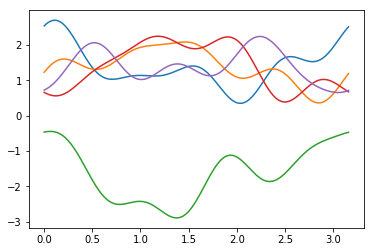

In [6]:
import matplotlib.pyplot as plt 
data = simulateTrajectory(trajectory)
data_y = np.array(data['positions'])
data_x = np.array(data['times'])
plt.plot(data_x ,data_y[:,0] ,label='joint1')
plt.plot(data_x ,data_y[:,1] ,label='joint2')
plt.plot(data_x ,data_y[:,2] ,label='joint3')
plt.plot(data_x ,data_y[:,3] ,label='joint4')
plt.plot(data_x ,data_y[:,4] ,label='joint5')

In [7]:
from identification.helpers import URDFHelpers

cnt = 0
traversal = iDynTree.Traversal()
model = iDynTree.Model()
iDynTree.modelFromURDF('model/youbot_arm_only.urdf', model)
success = model.computeFullTreeTraversal(traversal)

rotation = iDynTree.Rotation(1.0, 0.0, 0.0,
                             0.0, 1.0, 0.0,
                             0.0, 0.0, 1.0)
position = iDynTree.Position(0.0, 0.0, 0.0)
worldHbase = iDynTree.Transform(rotation, position)
jointPosition = iDynTree.VectorDynSize(5)
for q in data_y:
    for i in range(len(q)):
        jointPosition[i] = q[i]

    linkPositions = iDynTree.LinkPositions(model) 
    iDynTree.ForwardPositionKinematics(model, traversal, worldHbase,jointPosition, linkPositions)
    pose_link5 = linkPositions(5)
    z = pose_link5.getPosition().getVal(2)
    origin = (0, 0 , 0)
    end_eff = (pose_link5.getPosition().getVal(0), pose_link5.getPosition().getVal(1), pose_link5.getPosition().getVal(2))
    dist = distance.euclidean(origin, end_eff)
    
    
    if(z<0.08):
        print("collision ground")
        cnt+=1
    if (dist<0.1):
        print("collision link1")
           


In [27]:
from iDynTree import DynamicsComputations

URDF_FILE = 'model/youbot_arm_only.urdf'

dynComp = DynamicsComputations()
dynComp.loadRobotModelFromFile(URDF_FILE);
print ("The loaded model has", dynComp.getNrOfDegreesOfFreedom(), \
"internal degrees of freedom and",dynComp.getNrOfLinks(),"links.")

dofs = dynComp.getNrOfDegreesOfFreedom()
q = iDynTree.VectorDynSize(dofs)
dq = iDynTree.VectorDynSize(dofs)
ddq = iDynTree.VectorDynSize(dofs)
for dof in range(dofs):
    # For the sake of the example, we fill the joints vector with gibberish data (remember in any case
    # that all quantities are expressed in radians-based units 
    q.setVal(dof, 1.0)
    dq.setVal(dof, 0.4)
    ddq.setVal(dof, 0.3)


# The spatial acceleration is a 6d acceleration vector. 
# For all 6d quantities, we use the linear-angular serialization
# (the first three value are for the linear quantity, the 
#  the last  three values are for the angular quantity)
gravity = iDynTree.SpatialAcc()
gravity.zero()
gravity.setVal(2, -9.81)
dynComp.setRobotState(q,dq,ddq,gravity)

jac = iDynTree.MatrixDynSize(6,6+dofs)
ok = dynComp.getFrameJacobian("youBot", jac)
if( not ok ):
    print ("Error in computing jacobian of frame " + "youBot")
else: 
    print ("Jacobian of youBot is\n" + jac.toString())
    
links = dynComp.getNrOfLinks()

regr = iDynTree.MatrixDynSize(6+dofs,10*links)
ok = dynComp.getDynamicsRegressor(regr)
if( not ok ):
    print "Error in computing the dynamics regressor"
else :
    print "The dynamics regressor is\n" + regr.toString()

('The loaded model has', 5, 'internal degrees of freedom and', 6, 'links.')
Error in computing jacobian of frame youBot
The dynamics regressor is
0 0 0 6.91213e-310 0 0 0 0 0 0 -3.97859e+87 0.338509 0.0318093 -3.18287e+88 0 0 0 0 0 0 -4.47591e+87 0 0 -3.18287e+88 0 0 0 0 0 0 -4.97323e+87 -1.59143e+88 -3.97859e+87 -0.0675935 0 0 0 0 0 0 -1.5417e+88 -1.59143e+88 -3.97859e+87 3.18287e+88 0 0 0 0 0 0 -1.5417e+88 1.30547e+87 0 -6.4652e+87 0 0 0 0 0 0 
0 0 0 4.69752e+104 0 0 0 0 0 0 4.50962e+103 -0.0318093 0.338509 4.69752e+104 0 0 0 0 0 0 5.40214e+103 6.29745e+103 3.97859e+87 4.65511e+104 0 0 0 0 0 0 1.26176e+104 1.26259e+104 7.95717e+87 -4.52466e+104 0 0 0 0 0 0 6.50928e+103 -2.3212e+104 0 -4.08395e+104 0 0 0 0 0 0 1.24657e+103 8.01668e+103 2.17837e+104 -4.08395e+104 0 0 0 0 0 0 
9.81 -6.91213e-310 -4.69752e+104 0 0 0 0 0 0 0 1.49197e+87 -4.3335e+104 1.81312e+104 0 0 0 0 0 0 0 -1.43006e+103 -4.29439e+104 1.81312e+104 5.80946e+103 0 0 0 0 0 0 -5.2959e+102 4.17404e+104 1.81312e+104 1.16475e+

In [28]:
torques = iDynTree.VectorDynSize(dofs+6)
baseReactionForce = iDynTree.Wrench()

# compute id with inverse dynamics
dynComp.inverseDynamics(torques, baseReactionForce)
print(torques)


-7.0205e+101 1.55824e+103 -1.21566e+103 -1.36248e+102 -9.5195e+99 


In [11]:
data = np.load('/home/admin/rnd_test/FloBaRoID/measurements (1).npz')

[[ 0.04713685  0.02654622 -0.00798054  0.00982277  0.01646196]
 [ 0.04713089  0.02669502 -0.00803639  0.00981274  0.01669904]
 [ 0.04711255  0.02683568 -0.00809878  0.00980919  0.01694126]
 ..., 
 [ 0.04709084  0.02610112 -0.00786068  0.00988248  0.01584439]
 [ 0.0471183   0.0262718  -0.00789948  0.00985502  0.01606708]
 [ 0.04713352  0.02643449 -0.00794443  0.00983394  0.01629513]]


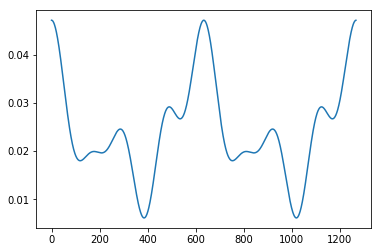

In [18]:
print(data['target_positions'])
y=data['target_positions']
x=data['times']
plt.plot( y[:,0] ,label='joint1')


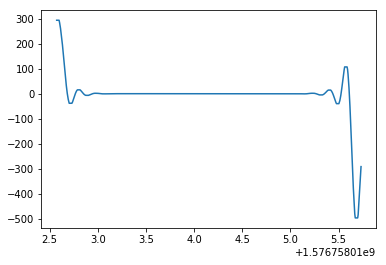

In [23]:
y=data['accelerations']
x=data['times']
plt.plot( x,y[:,0] ,label='joint1')

In [24]:
print(data['positions_raw'])

[[ 1.36095405 -1.29323662  1.6197565   1.36452862 -1.29086471]
 [ 1.61471225  1.36890872 -1.28819436  1.60769898  1.37366139]
 [-1.28539834  1.60072995  1.37749776 -1.28304215  1.59579632]
 ..., 
 [ 1.63688053 -1.2265249   1.34393794  1.63688053 -1.2265249 ]
 [ 1.34393794  1.63688053 -1.2265249   1.34393794  1.63688053]
 [-1.2265249   1.34393794  1.63688053 -1.2265249   1.34393794]]
